<a href="https://colab.research.google.com/github/saharkhsrvi/hugging-face-demo1/blob/main/Copy_of_Dandy_CV_Practical_Exercise_(2025_05_12_Sahar_Khosravi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __CV Practical Exercise__

In this exercise, you are given a script that trains a simple image classification model on a generated dataset of differently colored shapes.

Currently, this script does not achieve good accuracy on a validation dataset. Your task is to find ways to improve the accuracy of this model. Given the limited time, you might want to do some planning and prioritization before jumping into this exercise. Note that there are no deliberate coding bugs that were introduced; rather, the code was written by an inexperienced researcher.

You may use online resources and references as needed.

## Import definitions

In [ ]:
from dataclasses import dataclass
import collections
import json
import multiprocessing
import os
import traceback

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter

## Data processing routines

In [ ]:
@dataclass
class Datapoint:
    """Represents one datapoint.
    This structure is flexible enough to support both detection and segmentation."""
    image_id: int
    image: np.ndarray  # (H, W, 3) dtype uint8 representing image
    boxes: np.ndarray  # (N, 5) dtype np.int32 representing list of boxes (xmin, ymin, width, height, class)
    mask: np.ndarray  # (H, W) dtype np.int32 representing class mask

def read_dataset_categories(dataset_dir, split_name):
    with open(f'{dataset_dir}/annotations/instances_{split_name}.json', 'r') as fi:
        obj = json.load(fi)
    return obj['categories']

def read_dataset(dataset_dir, split_name):
    with open(f'{dataset_dir}/annotations/instances_{split_name}.json', 'r') as fi:
        obj = json.load(fi)

    # Load annotations into an index
    index = collections.defaultdict(list)  # map of image id to annotation
    for annotation in obj['annotations']:
        index[annotation['image_id']].append(annotation)

    # Iterate through images
    images_info = obj['images']
    for i, image_info in enumerate(images_info):
        filename = image_info['file_name']
        annotations = index[image_info['id']]

        with Image.open(os.path.join(dataset_dir, split_name, filename)) as f:
            img = np.asarray(f)

        mask = np.zeros(img.shape[:2], dtype=np.int32)
        boxes = []
        for annotation in annotations:
            xmin, ymin, width, height = map(int, annotation['bbox'])
            class_id = annotation['category_id']
            boxes.append([xmin, ymin, width, height, class_id])
            mask[ymin: ymin + height, xmin: xmin + width] = class_id

        yield Datapoint(image_info['id'], img, boxes, mask)


In [ ]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.1, contrast =0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=0.2, std=0.2),
                                      ])

val_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=0.2, std=0.2)])

## Dataset definition

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, split_name, transforms=None):
        self.datapoints = list(read_dataset(dataset_dir, split_name))
        self.transform = transforms

    def __getitem__(self, idx):
        datapoint = self.datapoints[idx]
        img = datapoint.image.transpose(2, 0, 1).copy()  # (C, H, W)
        target = datapoint.boxes[0][-1] - 1
        img = torch.as_tensor(img, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.datapoints)


## Network architecture definition

In [ ]:
class Network(nn.Module):
    def __init__(self, height, width, num_classes):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        h = (height - 4) // 2 - 4
        w = (width - 4) // 2 - 4
        self.fc_input = 24 * h * w
        self.fc1 = nn.Linear(self.fc_input, num_classes)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn4(self.conv4(output)))
        output = F.relu(self.bn5(self.conv5(output)))
        output = output.view(-1, self.fc_input)
        output = self.fc1(output)
        return output


## Training loop definition

In [ ]:
def train_model(dataset_dir, transforms):
    dataset_train = Dataset(dataset_dir, 'train')
    dataset_val = Dataset(dataset_dir, 'val')
    categories = read_dataset_categories(dataset_dir, 'train')
    num_classes = len(categories)
    height = 100
    width = 120

    dataloader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=10, shuffle=True, num_workers=2)
    dataloader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=2)

    model = Network(height, width, num_classes)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(dataloader_train, 0):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(dataloader_train)
        val_acc = evaluate(model, device, dataloader_val)
        print(f'epoch {epoch} loss: {train_loss:.4f}, val acc: {val_acc}')


## Evaluation function definition

In [ ]:
def evaluate(model, device, dataloader):
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    return accuracy / total


## Let's train the model!


In [ ]:
dataset_dir = 'datasets/image_classification'

Counts of labels: 
 Counter({8: 76, 9: 76, 10: 76, 4: 40, 5: 40, 6: 40, 7: 40, 1: 4, 2: 4, 3: 4})


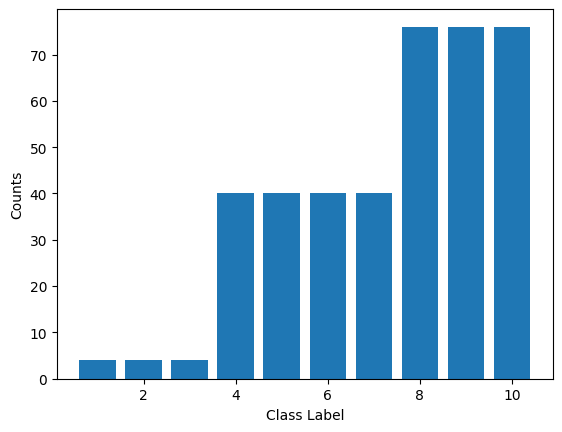

In [ ]:
datapoints = list(read_dataset('datasets/image_classification', 'train'))

labels = [datapoint.boxes[0][-1] for datapoint in datapoints]
counts = Counter(labels)
print("Counts of labels: \n", counts)

plt.bar(counts.keys(), counts.values())
plt.xlabel("Class Label")
plt.ylabel("Counts")
plt.show()

In [ ]:
nums_samples = len(labels)
class_weight = {cls: nums_samples/count for cls, count in counts.items()}
sample_weight = [class_weight[label] for label in labels]
print("Sample weight:\n", sample_weight)

Sample weight:
 [100.0, 100.0, 100.0, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 100.0, 100.0, 100.0, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 100.0, 100.0, 100.0, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 100.0, 100.0, 100.0, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 5.2631578947368425, 10.0, 10.0, 10.0, 10.0, 5.2631578947368425, 5.2631578947368425, 5.26315

In [ ]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights = sample_weight, num_samples=len(sample_weight), replacement = True)
train_loader = torch.utils.data.DataLoader(datapoints, batch_size = 32, sampler = sampler)


In [ ]:
train_model(dataset_dir, transforms=train_transforms)

epoch 0 loss: 5.6077, val acc: 0.14
epoch 1 loss: 3.1112, val acc: 0.48
epoch 2 loss: 2.2976, val acc: 0.3
epoch 3 loss: 1.9245, val acc: 0.36
epoch 4 loss: 2.0061, val acc: 0.41
epoch 5 loss: 1.2280, val acc: 0.42
epoch 6 loss: 1.0257, val acc: 0.52
epoch 7 loss: 0.8482, val acc: 0.31
epoch 8 loss: 0.7571, val acc: 0.2
epoch 9 loss: 1.3117, val acc: 0.35
epoch 10 loss: 0.4040, val acc: 0.3
epoch 11 loss: 0.7601, val acc: 0.42
epoch 12 loss: 0.4983, val acc: 0.44
epoch 13 loss: 0.3232, val acc: 0.41
epoch 14 loss: 0.2570, val acc: 0.19
epoch 15 loss: 0.1648, val acc: 0.39
epoch 16 loss: 0.3815, val acc: 0.3
epoch 17 loss: 0.2173, val acc: 0.37
epoch 18 loss: 0.1537, val acc: 0.3
epoch 19 loss: 0.0524, val acc: 0.48
epoch 20 loss: 0.3950, val acc: 0.14
epoch 21 loss: 0.2314, val acc: 0.41
epoch 22 loss: 0.2792, val acc: 0.44
epoch 23 loss: 0.0354, val acc: 0.48
epoch 24 loss: 0.0897, val acc: 0.47
epoch 25 loss: 0.0746, val acc: 0.48
epoch 26 loss: 0.0245, val acc: 0.49
epoch 27 loss: 0

Notice that our validation accuracy is not great, even though training loss is going down. Let's see if we can improve our model performance during this session.

Feel free to briefly jot down your thoughts and ideas, prioritize them and then start adjusting the code in this notebook.